<a href="https://colab.research.google.com/github/mridul0703/Cab-fare-Prediction/blob/main/Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset: new-york-city-taxi-fare-prediction

# Connection With Kaggle

In [193]:
# Install Kaggle API in Colab
!pip install kaggle

In [194]:
# Download kaggle.json

# -Go to the kaggle website.
# -Click on Your profile button on the top right and then select My Account.
# -Scroll down to the API section and click on the Create New API Token button.
# -It will initiate the download of a file call kaggle.json. Save the file at a known location on your machine.

# Authenticating with Kaggle using kaggle.json
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (3).json
User uploaded file "kaggle (3).json" with length 68 bytes
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [195]:
#! kaggle competitions download -c new-york-city-taxi-fare-prediction

In [196]:
#! mkdir train
#! unzip new-york-city-taxi-fare-prediction -d train

# Load Dataset

In [197]:
# Import libraries
import numpy as np
import pandas as pd
import csv
import re
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import time
from math import radians, cos, sin, asin, sqrt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [198]:
# Read data in pandas dataframe, skipping lines
def dataloader(path, step):
  def skip_rows(index):
      if index % step == 0 or index == 0:
        return False
      else:
        return True
  # Keep last n samples for test
  df =  pd.read_csv(path, skiprows = lambda x: skip_rows(x), parse_dates=['pickup_datetime'])
  return df

df = dataloader('train/train.csv',step=70)

In [199]:
df.shape

(1468, 8)

# Preprocessing

## Feature Extraction


In [200]:
df['year'] = df.pickup_datetime.apply(lambda t: t.year)
df['month'] = df.pickup_datetime.apply(lambda t: t.month)
df['weekday'] = df.pickup_datetime.apply(lambda t: t.weekday())
df['weekend'] = df['weekday'].apply(lambda t: 1 if t in [5,6] else 0)
df['hour'] = df.pickup_datetime.apply(lambda t: t.hour)
df['minute'] = df.pickup_datetime.apply(lambda t: t.minute)

df['month_sin'] = np.sin((df['month'] - 1) * (2. * np.pi / 12))
df['weekday_sin'] = np.sin((df['weekday'] - 1) * (2. * np.pi / 7))
df['hour_sin'] = np.sin((df['hour'] + df['minute'] / 60) * (2. * np.pi / 24))

# abs of delta of longitude and latitude pickup-dropoff
df['delta_longitude'] = abs(df.pickup_longitude - df.dropoff_longitude)
df['delta_latitude'] = abs(df.pickup_latitude - df.dropoff_latitude)
# peak_hours
df['peak_hours'] = df['hour'].apply(lambda x: 1 if x in [18,19,20] else 0)

In [201]:
# Function to find direction in degrees (Source: https://gist.github.com/jeromer/2005586)
def get_direction(lat1, lon1, lat2, lon2):
  lon1=lon1.to_numpy()
  lat1=lat1.to_numpy()
  lon2=lon2.to_numpy()
  lat2=lat2.to_numpy()
  diff_lon = np.deg2rad(lon2-lon1)
  x = np.sin(diff_lon) * np.cos(lat2)
  y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(diff_lon))
  initial_bearing = np.arctan2(x, y)

  # Now we have the initial bearing but math.atan2 return values
  # from -180° to + 180°.
  direction = np.degrees (initial_bearing)
  # Now we have the initial bearing but math.atan2 return values
  # from -180° to + 180° which is not what we want for a compass bearing
  # The solution is to normalize the initial bearing as shown below
  initial_bearing = np.degrees (initial_bearing)
  direction = (initial_bearing + 360) % 360
  return direction


# Haversine Formula, distance calculation (between pick-up and drop-off coordinates)
#(Source: https://www.igismap.com/haversine-formula-calculate-geographic-distance-earth/)
def haversine(lat1, lon1, lat2, lon2):
  # convert decimal degrees to radians
  lon1=np.deg2rad(lon1.to_numpy())
  lat1=np.deg2rad(lat1.to_numpy())
  lon2=np.deg2rad(lon2.to_numpy())
  lat2=np.deg2rad(lat2.to_numpy())
  # haversine formula
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
  c = 2 * np.arcsin(np.sqrt(a))
  r = 6372.8 # Radius of earth in kilometers. Use 3956 for miles
  return np.around(c * r, decimals=2)


# Load file with polygon coordinates
def merge(list1, list2):
  merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
  return merged_list


# Function to find points pick_up at airports
def in_airport(x1,y1,x2,y2,airport):
  for icoord, (x,y) in enumerate(zip([x1,x2], [y1,y2])):
    point = Point(float(x), float(y))
    found = 0
    polygon = Polygon(airport)
    if polygon.contains(point) == True:
      found = 1
      return found
  return found

# Function for fares from/to Manhattan
def in_manhattan(manhattan, x, y):
  point = Point(float(x), float(y))
  found = 0
  polygon = Polygon(manhattan)
  if polygon.contains(point) == 1:
    found = 1
    return found
  return found

In [202]:
# Create columns 'direction', 'distance_km'
df['direction'] = get_direction(df['pickup_latitude'], df['pickup_longitude'], \
                                      df['dropoff_latitude'], df['dropoff_longitude'])

df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'], \
                                      df['dropoff_latitude'], df['dropoff_longitude'])


# Load data coordinates for NYC airports
JFK = open('/content/train/JFK2.txt','r')
LAGUARDIA = open('/content/train/LaGuardia2.txt','r')
NEWARK = open('/content/train/Newark2.txt','r')
airports = []

jfk_coords = (40.639722, -73.778889)
lga_coords = (40.77725, -73.872611)
nwk_coords = (40.6925, -74.168611)

for airport in [JFK, LAGUARDIA,NEWARK]:
  for line in airport:
    line = line.split(',')
    polygon_y = [ np.float64(i) for i in line[::2] ]
    polygon_x = [ np.float64(i) for i in line[1::2] ]
    airports.append(merge(polygon_x, polygon_y))

# Find how many fares begin/end at an airport
df['JFK']=df.apply(lambda x: in_airport(x['dropoff_latitude'], x['dropoff_longitude'], x['pickup_latitude'], x['pickup_longitude'], airports[0]),axis=1)
df['LGA']=df.apply(lambda x: in_airport(x['dropoff_latitude'], x['dropoff_longitude'], x['pickup_latitude'], x['pickup_longitude'], airports[1]),axis=1)
df['NWK']=df.apply(lambda x: in_airport(x['dropoff_latitude'], x['dropoff_longitude'], x['pickup_latitude'], x['pickup_longitude'], airports[2]),axis=1)


# Load data coordinates for Manhattan
manhattan_ = open('/content/train/Manhattan.txt','r')
for line in manhattan_:
  line = line.split(',')
  polygon_y = [ np.float64(i) for i in line[::2] ]
  polygon_x = [ np.float64(i) for i in line[1::2] ]
  manhattan = (merge(polygon_x, polygon_y))
manhattan_.close()

# Find how many fares begin/end at Manhattan
df['dropoff_manhattan'] = df.apply(lambda x: in_manhattan(manhattan, x['dropoff_latitude'], x['dropoff_longitude']),axis=1)
df['pickup_manhattan'] = df.apply(lambda x: in_manhattan(manhattan, x['pickup_latitude'], x['pickup_longitude']),axis=1)

In [203]:
# Take inflation into account
def inflation(infl, df1, df2):
  inflated_fare = [0 for i in range(len(df1))]
  inflated_fare = df2['year'].map(infl) * df1#.fare_amount
  res = inflated_fare
  return res

def inverse_inflation(infl, df1, df2):
  inflated_fare = [0 for i in range(len(df1))]
  inflated_fare = df1 / df2['year'].map(infl)
  res = inflated_fare
  return res

#Scaling inflation to 2009 values
infl = {
    2009: 1/1.    ,
    2010: 1/1.0164,
    2011: 1/1.0485,
    2012: 1/1.0702,
    2013: 1/1.0859,
    2014: 1/1.1035,
    2015: 1/1.1048
}

df['inflated_fare'] = inflation(infl, df['fare_amount'], df)

## Clean Data



### General


*   Drop Nan values
*   Drop negative value 'fare_amount' and over 200 $
*   Drop 'passenger_count' value under 1 and over 7
*   Drop outliers with low 'distance_km' and high 'fare_amount'
*   Drop outliers in coordinates
*   Drop 'key' column



In [204]:
print('Old size: %d' % len(df))
df= df.dropna(how = 'any', axis = 'rows')
df = df[(df['fare_amount']>0) & (df['fare_amount']<200)]
df = df[(df['passenger_count']>0) & (df['passenger_count']<=12)]
df = df[-((df['fare_amount']>70) & (df['distance_km']<5))]
df = df[df['distance_km']!=0]

df = df[(df['pickup_longitude']<-65) & (-85<df['pickup_longitude'])]
df = df[(30<df['pickup_latitude']) & (df['pickup_latitude']<55)]

df = df[(df['dropoff_longitude']<-65) & (-85<df['dropoff_longitude'])]
df = df[(30<df['dropoff_latitude']) & (df['dropoff_latitude']<55)]

df = df.drop(columns='key')
print('New size: %d' % len(df))

Old size: 1468
New size: 1402


###  Geospatial Data

Plot Geospatial Data

In [205]:
def plot_geodata(df, box, nyc_map, s=10, alpha=0.2):
  fig, axs = plt.subplots(1, 2, figsize=(16,10))
  axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='g', s=s)
  axs[0].set_xlim((box[0], box[1]))
  axs[0].set_ylim((box[2], box[3]))
  axs[0].set_title('Pickup locations')
  axs[0].imshow(nyc_map, zorder=0, extent=box)

  axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='g', s=s)
  axs[1].set_xlim((box[0], box[1]))
  axs[1].set_ylim((box[2], box[3]))
  axs[1].set_title('Dropoff locations')
  axs[1].imshow(nyc_map, zorder=0, extent=box)

def select_within_boundingbox(df, box):
  return (df.pickup_longitude >= box[0]) & (df.pickup_longitude <= box[1]) & \
           (df.pickup_latitude >= box[2]) & (df.pickup_latitude <= box[3]) & \
           (df.dropoff_longitude >= box[0]) & (df.dropoff_longitude <= box[1]) & \
           (df.dropoff_latitude >= box[2]) & (df.dropoff_latitude <= box[3])

def lonlat_to_xy(longitude, latitude, dx, dy, box):
  return (dx*(longitude - box[0])/(box[1]-box[0])).astype('int'), \
              (dy - dy*(latitude - box[2])/(box[3]-box[2])).astype('int')

def remove_datapoints_from_water(df):
  # define bounding box
  box = (-74.5, -72.8, 40.5, 41.8)

  # read nyc mask and turn into boolean map with
  # land = True, water = False
  nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9

  # calculate for each lon,lat coordinate the xy coordinate in the mask map
  pickup_x, pickup_y = lonlat_to_xy(df['pickup_longitude'], df['pickup_latitude'],
                                      nyc_mask.shape[1], nyc_mask.shape[0], box)
  dropoff_x, dropoff_y = lonlat_to_xy(df['dropoff_longitude'], df['dropoff_latitude'],
                                      nyc_mask.shape[1], nyc_mask.shape[0], box)
  # calculate boolean index
  idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])

  # return only datapoints on land
  return df[idx]

As can be seen from the map above, some samples are located in the water, so we can remove them.
(source https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration)


Clear and plot the new data

## General Analysis

In [206]:
# check statistics of the features
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,weekend,...,delta_latitude,peak_hours,direction,distance_km,JFK,LGA,NWK,dropoff_manhattan,pickup_manhattan,inflated_fare
count,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,...,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000
mean,11.062432,-73.976735,40.750614,-73.975772,40.750497,1.652639,2011.819544,6.169757,2.975036,0.266762,...,0.021877,0.181883,211.785709,3.333317,0.015692,0.029957,0.001427,0.884451,0.930813,10.416802
std,9.174049,0.031480,0.040133,0.032751,0.030310,1.283463,1.849310,3.442771,1.943919,0.442425,...,0.037852,0.385886,121.545553,4.769176,0.124325,0.170530,0.037756,0.319798,0.253862,8.513183
min,2.500000,-74.032768,39.607752,-74.218719,40.535355,1.000000,2009.000000,1.000000,0.000000,0.000000,...,0.000007,0.000000,0.002316,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,2.265519
25%,6.000000,-73.991973,40.736425,-73.992126,40.735795,1.000000,2010.000000,3.000000,1.000000,0.000000,...,0.006743,0.000000,178.556183,1.240000,0.000000,0.000000,0.000000,1.000000,1.000000,5.525371
50%,8.100000,-73.982387,40.753191,-73.980709,40.752711,1.000000,2012.000000,6.000000,3.000000,0.000000,...,0.013444,0.000000,180.091182,2.110000,0.000000,0.000000,0.000000,1.000000,1.000000,7.714043
75%,12.500000,-73.970675,40.767462,-73.966032,40.768130,2.000000,2013.000000,9.000000,5.000000,1.000000,...,0.026900,0.000000,358.369613,3.900000,0.000000,0.000000,0.000000,1.000000,1.000000,11.780698
max,80.750000,-73.725993,40.842628,-73.709510,40.870485,6.000000,2015.000000,12.000000,6.000000,1.000000,...,1.143344,1.000000,359.996183,127.170000,1.000000,1.000000,1.000000,1.000000,1.000000,74.362280


## Feature Interaction

<Axes: >

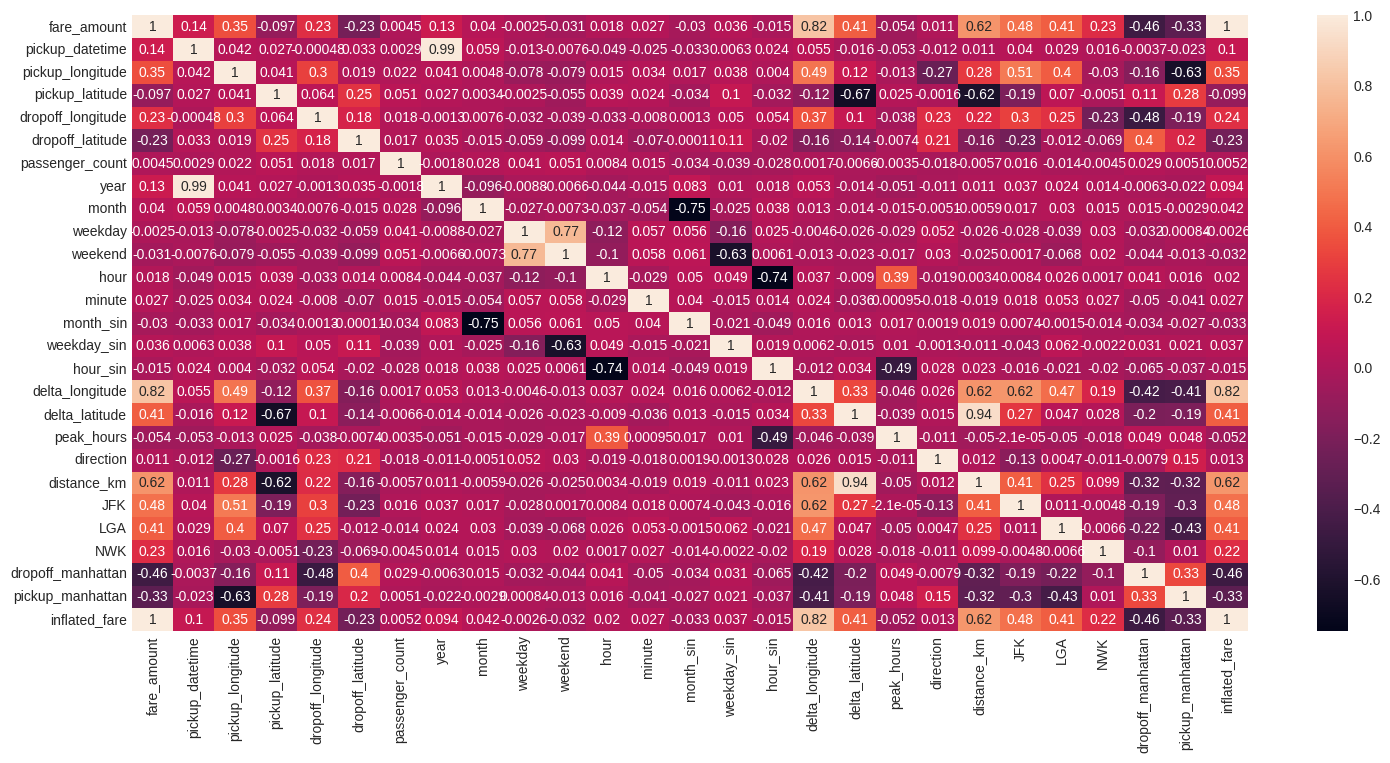

In [207]:
plt.figure(figsize = (18,8))
corr = df.corr()
corr
sns.heatmap(corr, annot = True)

## Plots

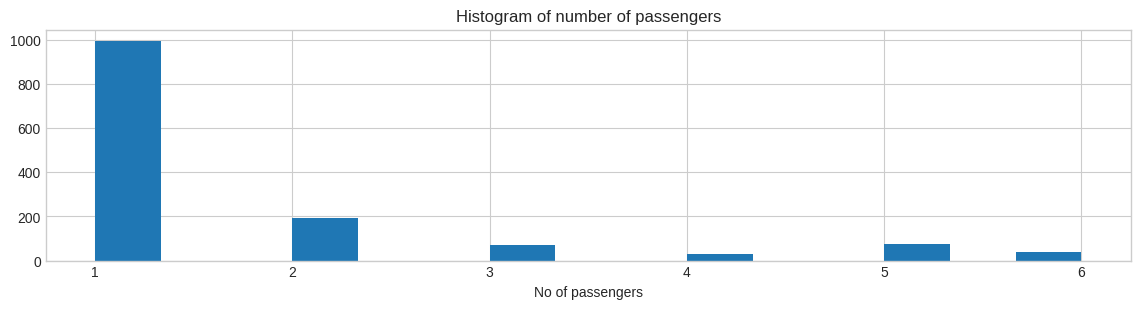

In [208]:
# Plot histogram of passengers
df.passenger_count.hist(bins=15, figsize=(14,3))
plt.xlabel('No of passengers')
plt.title('Histogram of number of passengers');

<ipython-input-209-be0034023807>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


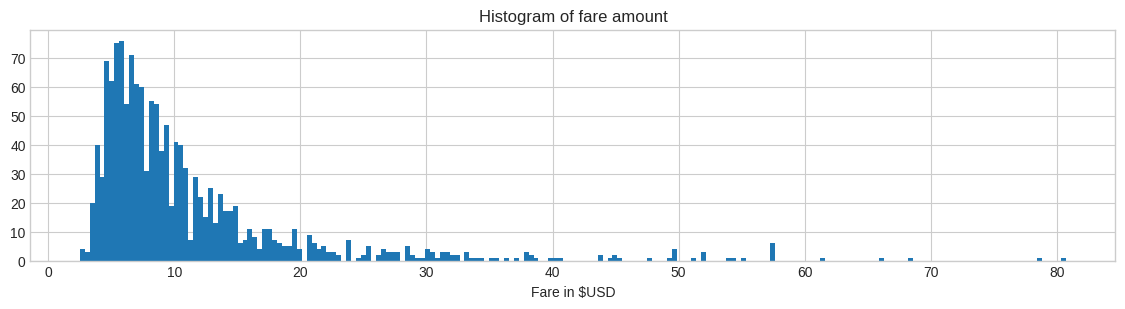

In [209]:
# matplotlib inline
plt.style.use('seaborn-whitegrid')

# Plot histogram of fare
df.fare_amount.hist(bins=200, figsize=(14,3))
plt.xlabel('Fare in $USD')
plt.title('Histogram of fare amount');

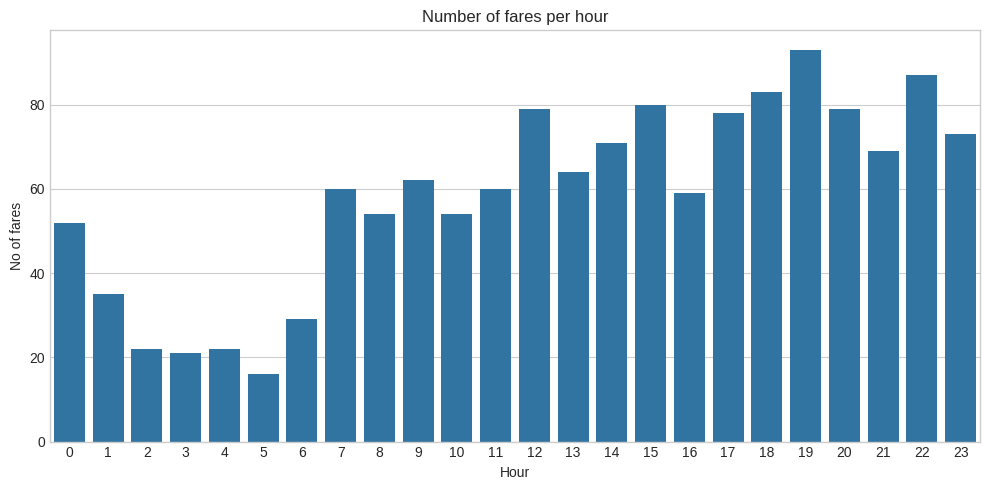

31800

In [210]:
# Plot histogram of fares per hour
plt.figure(figsize = (10,5))
new_df = df.groupby('hour', as_index = False)['fare_amount'].agg(['count']).sort_values(by = 'hour', ascending = True)
ax = sns.barplot(x=new_df.index, y=new_df['count'])
ax.set(xlabel='Hour', ylabel='No of fares')
plt.title('Number of fares per hour')
plt.tight_layout()
plt.show()
del new_df
gc.collect()

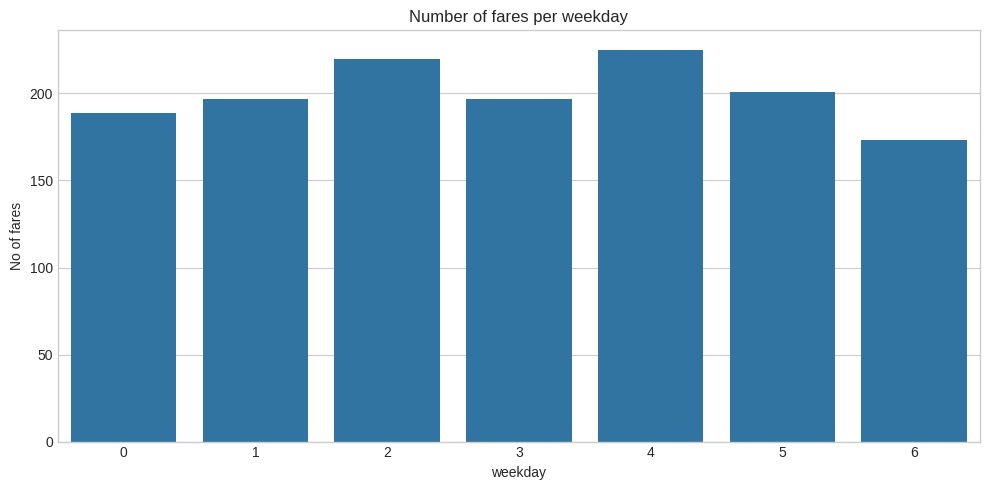

7747

In [211]:
# Plot histogram of fares per weekday
plt.figure(figsize = (10,5))
new_df = df.groupby('weekday', as_index = False)['fare_amount'].agg(['count']).sort_values(by = 'weekday', ascending = True)
ax = sns.barplot(x=new_df.index, y=new_df['count'])
ax.set(xlabel='weekday', ylabel='No of fares')
plt.title('Number of fares per weekday')
plt.tight_layout()
plt.show()
del new_df
gc.collect()

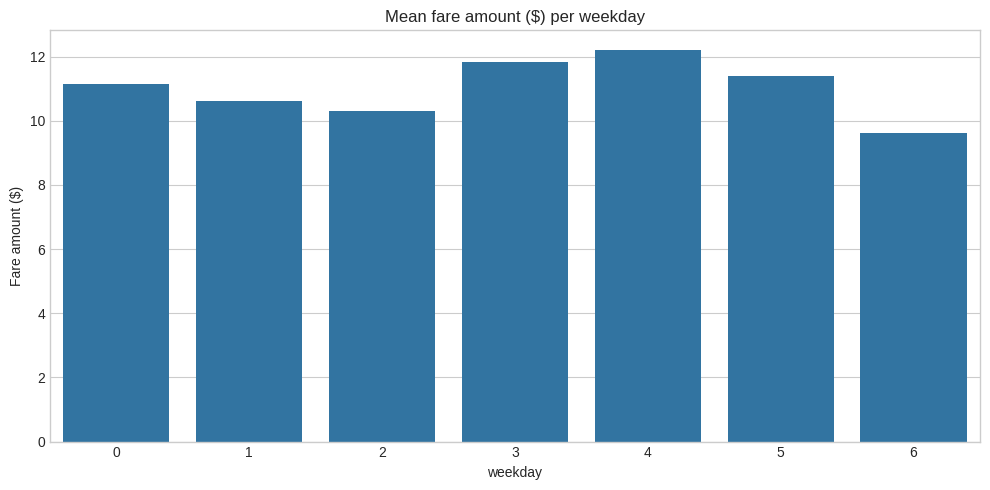

3975

In [212]:
# Plot histogram of fares per weekday
plt.figure(figsize = (10,5))
new_df = df.groupby('weekday', as_index = False)['fare_amount'].agg(['mean']).sort_values(by = 'weekday', ascending = True)
ax = sns.barplot(x=new_df.index, y=new_df['mean'])
ax.set(xlabel='weekday', ylabel='Fare amount ($)')
plt.title('Mean fare amount ($) per weekday')
plt.tight_layout()
plt.show()
del new_df
gc.collect()

<ipython-input-213-bbecf8df25a4>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["distance_km"],color = "b")


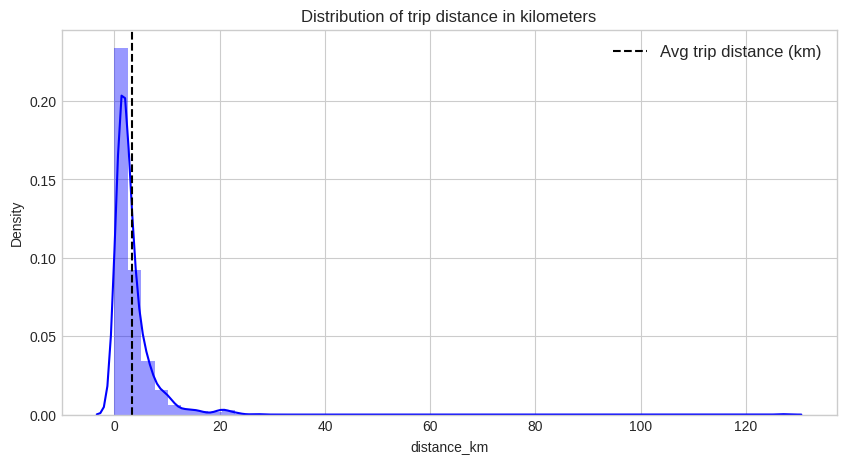

In [213]:
plt.figure(figsize = (10,5))
sns.distplot(df["distance_km"],color = "b")
plt.axvline(df["distance_km"].mean(),color = "k",
            linestyle = "dashed",label = "Avg trip distance (km)")
plt.title("Distribution of trip distance in kilometers")
plt.legend(loc = "best",prop = {"size" : 12})
plt.show()

# Machine Learning

In [214]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

import keras
from keras.datasets import mnist
from keras.initializers import TruncatedNormal
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
import keras.backend as K
import keras.optimizers as opt

import time
from sklearn import metrics

#### Split Data into Train, Test set

In [215]:
# Columns
#fare_amount  pickup_datetime 	pickup_longitude 	pickup_latitude 	dropoff_longitude 	dropoff_latitude 	passenger_count 	year 	month 	weekday 	hour 	minute 	delta_longitude 	delta_latitude 	peak_hours 	distance_km 	direction 	JFK 	LGA 	NWK 	inflated_fare 	dropoff_manhattan 	pickup_manhattan 	weekend

# For NN
# Keep whole dataset
df_x_nn = df[['pickup_longitude','dropoff_longitude','pickup_latitude',
              'dropoff_latitude','passenger_count','year','weekday','weekend','hour_sin','month_sin',
              'delta_longitude','delta_latitude','distance_km','direction',
              'dropoff_manhattan','pickup_manhattan','peak_hours','JFK','LGA',
              'NWK']].copy().astype(float)
df_y_nn = df['fare_amount'].copy()
# Split the data
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(df_x_nn, df_y_nn, test_size=0.2, random_state=42)

# For all ML algorithms except NN
# Keep only 20% of dataset and choose randomly
df_x, df_x_drop, df_y, df_y_drop = train_test_split(df_x_nn, df_y_nn, test_size=0.87, random_state=42)
df_x = df_x[['passenger_count','year','weekday','hour_sin','delta_longitude',
             'delta_latitude','distance_km','direction','dropoff_manhattan',
             'pickup_manhattan','peak_hours','JFK','LGA','NWK']].copy().astype(float)
# Split the data
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

print(df_x.shape)
print(df_x_nn.shape)

(182, 14)
(1402, 20)


In [216]:
# Dataframe to append ml algorithm evaluations for plotting
evaluation_df = pd.DataFrame({'name': [], 'mae': [], 'rmse': []})
# List to append ml algorithm Mean Absolute Error intervals for plotting
intervals_list = []

# The baseline predictions are the historical averages
# Baseline errors, and display average baseline error

baseline_preds = y_test.mean()
baseline_errors = abs(baseline_preds - y_test)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  6.43


## Functions

In [217]:
# Function to plot Mean Absolute Error intervals
def plot_intervals(interv_list):
  plt.figure(figsize=(15,5))
  interval_df=pd.DataFrame(interv_list,columns=['name','<1 $','<2 $','<3 $','<4 $','<5 $','<6 $','<7 $','<8 $','<9 $','<10 $'])
  plt.tight_layout()
  fig, ax = plt.subplots(figsize=(15,5))
  for i in range(0,len(interval_df.index)):
    ax.plot(interval_df.iloc[i,1:], label=interval_df.iloc[i,0])
  ax.legend(loc='lower right')
  plt.xlabel('Intervals')
  plt.title('Mean Absolute Error Intervals')


# Function to get Mean Absolute Error intervals
def get_intervals(name, err):
  samples_i=[]
  for i in range(1,11):
    samples_i.append(sum((err<=i)==True))
  scaled_samples_i = np.asarray(samples_i)/len(err)
  l = scaled_samples_i.tolist()
  l.insert(0, name)
  return l


# Function to fill a dataframe for evaluation of ML algorithms
def fill_df_for_evaluation(name, mae, rmse):
  return {'name' : name, 'mae' : mae, 'rmse' : rmse}


def add_results_to_df(name, predictions, y_test):
    global evaluation_df, intervals_list
    mae = metrics.mean_absolute_error(y_test, predictions)
    print('Mean Absolute Error:', mae)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
    print('Root Mean Squared Error:', rmse)
    errors = abs(predictions - y_test)

    new_row = fill_df_for_evaluation(name, mae, rmse)
    new_df = pd.DataFrame([new_row])

    evaluation_df = pd.concat([evaluation_df, new_df], ignore_index=True)
    intervals_list.append(get_intervals(name, errors))


# Function to create plot of Root Mean Squared Error of ML algorithms
def create_rmse_plot(evaluation_df):
  plt.figure(figsize = (12,5))
  eval_df = evaluation_df.sort_values(by=['rmse'], ascending=False)
  ax = sns.barplot(x=eval_df.name, y=eval_df.rmse)
  plt.xlabel('ML Algorithms')
  plt.xlabel('RMSE')
  plt.title('Root Mean Squared Error of ML algorithms');
  plt.tight_layout()
  plt.show()


# Function to create plot of Mean Absolute Error of ML algorithms
def create_mae_plot(evaluation_df):
  plt.figure(figsize = (12,5))
  eval_df = evaluation_df.sort_values(by=['mae'], ascending=False)
  ax = sns.barplot(x=eval_df.name, y=eval_df.mae)
  plt.xlabel('ML Algorithms')
  plt.ylabel('MAE ($)')
  plt.title('Mean Absolute Error of ML algorithms');
  plt.tight_layout()
  plt.show()

## Algorithms

### Linear Regression

LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [218]:
# StandardScaler + linear + Pipe
scaler = StandardScaler()
model = linear_model.LinearRegression(n_jobs=-1)
pipe = Pipeline(steps=[('scaler', scaler), ('model', model)], memory = 'tmp')

start_time = time.time()
pipe.fit(x_train,y_train)
predictions = pipe.predict(x_test)
print("Total time fit and predict: %s seconds" % (time.time() - start_time))

add_results_to_df('linear_regression',predictions,y_test)

Total time fit and predict: 0.009282588958740234 seconds
Mean Absolute Error: 3.5112920440001503
Root Mean Squared Error: 5.238764998128345


### Random Forest

A random forest regressor.
A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [219]:
# StandardScaler + rf + Pipe
scaler = StandardScaler()
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, n_jobs=-1)
pipe = Pipeline(steps=[('scaler', scaler), ('rf', rf)], memory = 'tmp')

start_time = time.time()
pipe.fit(x_train,y_train)
predictions = pipe.predict(x_test)
print("Total time fit and predict: %s seconds" % (time.time() - start_time))

add_results_to_df('random_forest',predictions,y_test)
del rf
gc.collect()

Total time fit and predict: 2.971846580505371 seconds
Mean Absolute Error: 2.511422162162178
Root Mean Squared Error: 4.410305133283902


6457

### Epsilon-Support Vector Regression

The free parameters in the model are C and kernel type

In [220]:
# Hyperparemeters selected after tuning
kernel = 'rbf'
C = 3

clf = SVR(kernel=kernel,C=C)
scaler = StandardScaler()

pipe = Pipeline(steps=[('scaler', scaler),('SVR', clf)])
start_time = time.time()
pipe.fit(x_train, y_train)
preds = pipe.predict(x_test)
print("Total time fit and predict: %s seconds" % (time.time() - start_time))

add_results_to_df('linear_svr',preds,y_test)

Total time fit and predict: 0.01884913444519043 seconds
Mean Absolute Error: 4.155629710128121
Root Mean Squared Error: 7.773273761401309


### XGBoost

XGBoost (Extreme Gradient Boosting) belongs to a family of boosting algorithms and uses the gradient boosting (GBM) framework at its core. It is an optimized distributed gradient boosting library.

In [221]:
#StandardScaler + xgboost + Pipe with parameters after using RandomizedSearchCV
scaler = StandardScaler()
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.11, gamma=0.003, subsample=0.91, colsample_bytree=0.69, max_depth=5)
pipe = Pipeline(steps=[('scaler', scaler), ('xgb', xgb_model)], memory = 'tmp')

start_time = time.time()
pipe.fit(x_train,y_train)
predictions = pipe.predict(x_test)
print("Total time fit and predict: %s seconds" % (time.time() - start_time))

add_results_to_df('xgboost',predictions,y_test)

Total time fit and predict: 0.7264080047607422 seconds
Mean Absolute Error: 2.6422353512532
Root Mean Squared Error: 4.883800794802142


### Voting Regressor
Prediction voting regressor for unfitted estimators.

A voting regressor is an ensemble meta-estimator that fits base regressors each on the whole dataset. It, then, averages the individual predictions to form a final prediction.

In [222]:
kernel = 'rbf'
C = 3

sv = SVR(kernel=kernel,C=C)
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, n_jobs=-1)
xg = xgb.XGBRegressor(n_estimators=108, learning_rate=0.11, gamma=0.003, subsample=0.91, colsample_bytree=0.69, max_depth=5)
scaler = StandardScaler()
clf = VotingRegressor([('rf', rf), ('xg', xg),('sv',sv)])

pipe = Pipeline(steps=[('scaler', scaler),('clf', clf)])

start_time = time.time()
pipe.fit(x_train, y_train)
preds = pipe.predict(x_test)
print("Total time fit and predict: %s seconds" % (time.time() - start_time))

add_results_to_df('voting_regressor',preds,y_test)

Total time fit and predict: 4.207717418670654 seconds
Mean Absolute Error: 2.656952085483682
Root Mean Squared Error: 5.27676706947508


### Bagging Regressor

A Bagging regressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

In [223]:
scaler = StandardScaler()
regr = BaggingRegressor(base_estimator=SVR(),n_estimators=7, random_state=42)
pipe = Pipeline(steps=[('scaler', scaler),('regr', regr)])

start_time = time.time()
pipe.fit(x_train,y_train)
preds = pipe.predict(x_test)
print("Total time fit and predict: %s seconds" % (time.time() - start_time))

add_results_to_df('bagging_regressor',preds,y_test)

Total time fit and predict: 0.044187068939208984 seconds
Mean Absolute Error: 4.928151729195096
Root Mean Squared Error: 8.961017621715104


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


### Histogram-based Gradient Boosting Regression Tree

This implementation is inspired by LightGBM.
This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently. If no missing values were encountered for a given feature during training, then samples with missing values are mapped to whichever child has the most samples.

In [224]:
start_time = time.time()
est = HistGradientBoostingRegressor().fit(x_train, y_train).fit(x_train,y_train)
preds = est.predict(x_test)
print("Total time fit and predict: %s seconds" % (time.time() - start_time))

add_results_to_df('histogram_grad_boost_reg',preds,y_test)

Total time fit and predict: 1.6120924949645996 seconds
Mean Absolute Error: 2.7361504726080668
Root Mean Squared Error: 5.245860596192425


### Neural Network
A neural network is expected to give one of the best potential results. It has to be fed a huge amount of data, so the dataset that will be used to train it, will be roughly 10 times larger. A multilayere network is used. Attempts were made with 1-hot encoding, as well as early stopping. However, the simple version ended up giving the best result. It was decided that all characteristics are to be used, and let the network decide their importance.

The following network projects the input into a increasingly larger space, in order to extract any high level characteristics, and then attempts to guess the value of the taxi fare.

In [225]:
#!pip install --upgrade tensorflow==1.15
#!pip install --upgrade keras

# Standard Scaling data
x_train_nn[x_train_nn.columns] = scaler.fit_transform(x_train_nn[x_train_nn.columns])
x_test_nn[x_test_nn.columns] = scaler.fit_transform(x_test_nn[x_test_nn.columns])

Epoch 1/20
32/36 [=========================>....] - ETA: 0s - loss: 163.1584 - mean_squared_error: 163.1584 - mean_absolute_error: 9.3536

36/36 [==============================] - 7s 9ms/step - loss: 158.8584 - mean_squared_error: 158.8584 - mean_absolute_error: 9.1405
Epoch 2/20
32/36 [=========================>....] - ETA: 0s - loss: 65.3273 - mean_squared_error: 65.3273 - mean_absolute_error: 4.2043

36/36 [==============================] - 0s 11ms/step - loss: 62.5332 - mean_squared_error: 62.5332 - mean_absolute_error: 4.1739
Epoch 3/20
34/36 [===========================>..] - ETA: 0s - loss: 29.0692 - mean_squared_error: 29.0692 - mean_absolute_error: 3.4828

36/36 [==============================] - 0s 11ms/step - loss: 40.1227 - mean_squared_error: 40.1227 - mean_absolute_error: 3.5740
Epoch 4/20
33/36 [==========================>...] - ETA: 0s - loss: 32.8506 - mean_squared_error: 32.8506 - mean_absolute_error: 3.3050

36/36 [==============================] - 0s 9ms/step - loss: 32.5427 - mean_squared_error: 32.5427 - mean_absolute_error: 3.2804
Epoch 5/20
34/36 [===========================>..] - ETA: 0s - loss: 26.0347 - mean_squared_error: 26.0347 - mean_absolute_error: 3.0672

36/36 [==============================] - 0s 12ms/step - loss: 27.3703 - mean_squared_error: 27.3703 - mean_absolute_error: 3.0881
Epoch 6/20
36/36 [==============================] - ETA: 0s - loss: 24.2536 - mean_squared_error: 24.2536 - mean_absolute_error: 2.8871

36/36 [==============================] - 1s 14ms/step - loss: 24.2536 - mean_squared_error: 24.2536 - mean_absolute_error: 2.8871
Epoch 7/20
33/36 [==========================>...] - ETA: 0s - loss: 22.2779 - mean_squared_error: 22.2779 - mean_absolute_error: 2.7483

36/36 [==============================] - 0s 10ms/step - loss: 21.4949 - mean_squared_error: 21.4949 - mean_absolute_error: 2.7152
Epoch 8/20
32/36 [=========================>....] - ETA: 0s - loss: 19.6243 - mean_squared_error: 19.6243 - mean_absolute_error: 2.6831

36/36 [==============================] - 0s 11ms/step - loss: 20.2243 - mean_squared_error: 20.2243 - mean_absolute_error: 2.6982
Epoch 9/20
35/36 [============================>.] - ETA: 0s - loss: 19.2511 - mean_squared_error: 19.2511 - mean_absolute_error: 2.6007

36/36 [==============================] - 0s 11ms/step - loss: 19.2443 - mean_squared_error: 19.2443 - mean_absolute_error: 2.6014
Epoch 10/20
31/36 [========================>.....] - ETA: 0s - loss: 19.2937 - mean_squared_error: 19.2937 - mean_absolute_error: 2.5880

36/36 [==============================] - 0s 9ms/step - loss: 17.9504 - mean_squared_error: 17.9504 - mean_absolute_error: 2.5275
Epoch 11/20
34/36 [===========================>..] - ETA: 0s - loss: 17.8128 - mean_squared_error: 17.8128 - mean_absolute_error: 2.5406

36/36 [==============================] - 0s 10ms/step - loss: 17.5193 - mean_squared_error: 17.5193 - mean_absolute_error: 2.5301
Epoch 12/20
34/36 [===========================>..] - ETA: 0s - loss: 17.3682 - mean_squared_error: 17.3682 - mean_absolute_error: 2.4948

36/36 [==============================] - 0s 10ms/step - loss: 17.2463 - mean_squared_error: 17.2463 - mean_absolute_error: 2.4983
Epoch 13/20
35/36 [============================>.] - ETA: 0s - loss: 16.4093 - mean_squared_error: 16.4093 - mean_absolute_error: 2.4425

36/36 [==============================] - 0s 14ms/step - loss: 16.3961 - mean_squared_error: 16.3961 - mean_absolute_error: 2.4414
Epoch 14/20
33/36 [==========================>...] - ETA: 0s - loss: 15.6315 - mean_squared_error: 15.6315 - mean_absolute_error: 2.3516

36/36 [==============================] - 0s 11ms/step - loss: 15.9814 - mean_squared_error: 15.9814 - mean_absolute_error: 2.3557
Epoch 15/20
36/36 [==============================] - ETA: 0s - loss: 15.7211 - mean_squared_error: 15.7211 - mean_absolute_error: 2.4011

36/36 [==============================] - 0s 11ms/step - loss: 15.7211 - mean_squared_error: 15.7211 - mean_absolute_error: 2.4011
Epoch 16/20
36/36 [==============================] - ETA: 0s - loss: 15.3743 - mean_squared_error: 15.3743 - mean_absolute_error: 2.3736

36/36 [==============================] - 0s 12ms/step - loss: 15.3743 - mean_squared_error: 15.3743 - mean_absolute_error: 2.3736
Epoch 17/20
36/36 [==============================] - ETA: 0s - loss: 14.7793 - mean_squared_error: 14.7793 - mean_absolute_error: 2.3393

36/36 [==============================] - 0s 11ms/step - loss: 14.7793 - mean_squared_error: 14.7793 - mean_absolute_error: 2.3393
Epoch 18/20
35/36 [============================>.] - ETA: 0s - loss: 15.0984 - mean_squared_error: 15.0984 - mean_absolute_error: 2.3333

36/36 [==============================] - 0s 13ms/step - loss: 15.0883 - mean_squared_error: 15.0883 - mean_absolute_error: 2.3329
Epoch 19/20
33/36 [==========================>...] - ETA: 0s - loss: 14.5228 - mean_squared_error: 14.5228 - mean_absolute_error: 2.2433

36/36 [==============================] - 0s 12ms/step - loss: 14.2017 - mean_squared_error: 14.2017 - mean_absolute_error: 2.2284
Epoch 20/20
33/36 [==========================>...] - ETA: 0s - loss: 15.1887 - mean_squared_error: 15.1887 - mean_absolute_error: 2.3588

36/36 [==============================] - 0s 12ms/step - loss: 14.6220 - mean_squared_error: 14.6220 - mean_absolute_error: 2.3308


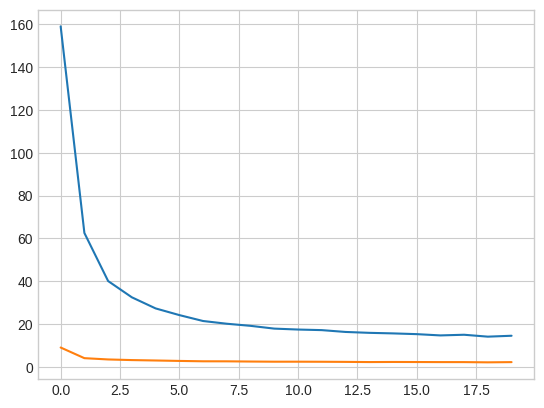

9/9 - 0s - loss: 21.9755 - mean_squared_error: 21.9755 - mean_absolute_error: 2.7331 - 360ms/epoch - 40ms/step
Total time fit and evaluate: 16.017871141433716 seconds
Testing set Mean Abs Error: 2.733 $
Testing set Mean Squared Error: 21.975
Testing set Root Mean Squared Error: 4.688


In [226]:
def build_model():
  model = Sequential()
  model.add(Dense(48, activation='relu', input_dim=20))
  model.add(Dense(96, activation='relu'))
  model.add(Dense(48, activation='relu'))
  model.add(Dense(24, activation='relu'))
  model.add(Dense(12, activation='relu'))
  model.add(Dense(6,  activation='relu'))
  model.add(Dense(1,  activation='relu'))

  optimizer = opt.RMSprop()
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])
  return model

# create model
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# train model
epochs = 20
batch_size = 32

start_time = time.time()
history = model.fit(
  x_train_nn, y_train_nn, epochs=epochs, batch_size=batch_size,  callbacks=[early_stop])
# Plot metrics
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.show()

loss, mse, mae = model.evaluate(x_test_nn, y_test_nn, verbose=2, batch_size=batch_size)
print("Total time fit and evaluate: %s seconds" % (time.time() - start_time))


new_row = fill_df_for_evaluation("neural_network", mae, np.sqrt(mse))
new_df = pd.DataFrame([new_row])
evaluation_df = pd.concat([evaluation_df, new_df], ignore_index=True)
print("Testing set Mean Abs Error: {:5.3f} $".format(mae))
print("Testing set Mean Squared Error: {:5.3f}".format(mse))
print("Testing set Root Mean Squared Error: {:5.3f}".format(np.sqrt(mse)))

## Results

Plot Root Mean Squared Error for each ML algorithm

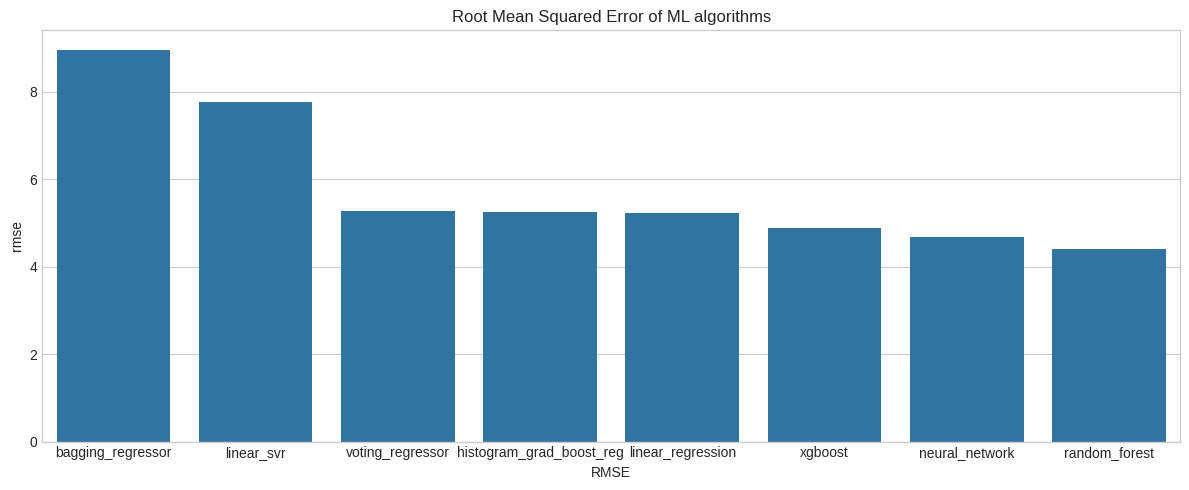

In [227]:
create_rmse_plot(evaluation_df)

Plot Mean Absolute Error each ML algorithm

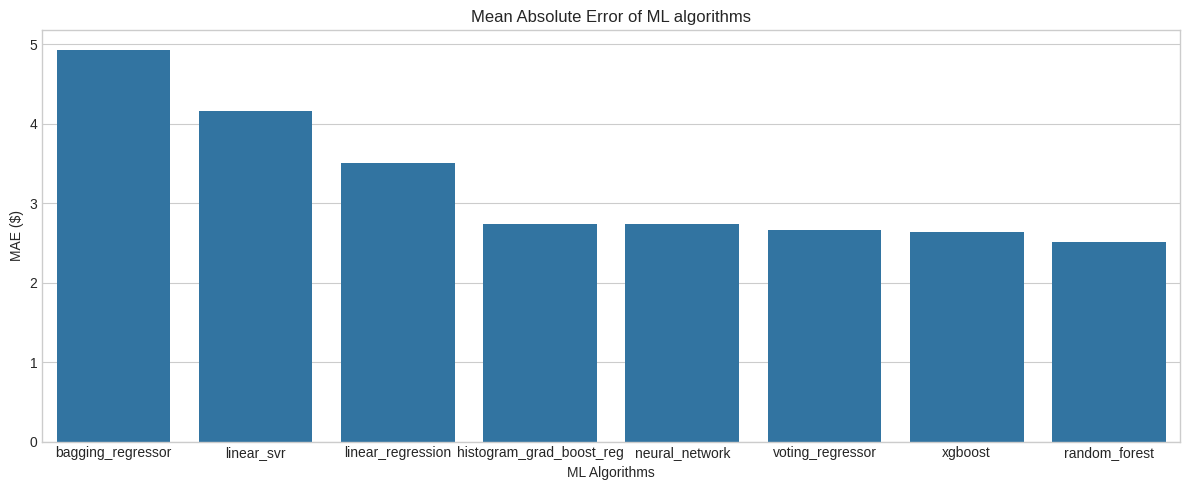

In [228]:
create_mae_plot(evaluation_df)

Plot MAE Error Intervals for each ML algorithm

<Figure size 1500x500 with 0 Axes>

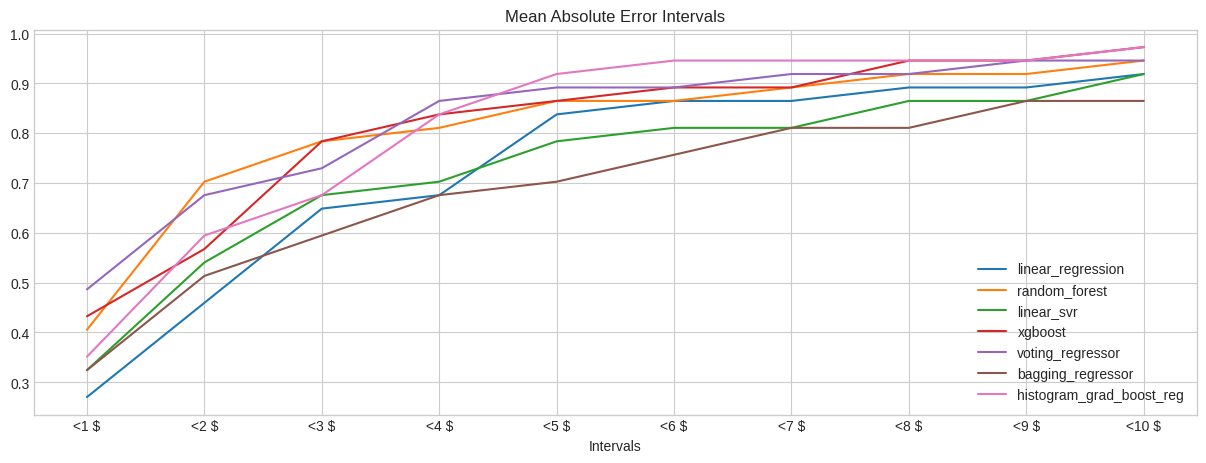

In [229]:
plot_intervals(intervals_list)